In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
import gc
pd.set_option('display.max_columns', None)

In [2]:
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for plotting
import matplotlib.pyplot as plt
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.preprocessing import LabelEncoder,Normalizer,StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## for explainer
#from lime import lime_tabular

In [3]:
#a = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week1.csv', low_memory=False, encoding='cp1252')
#b = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week2.csv', low_memory=False, encoding='cp1252')
a = pd.read_csv('./CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week1.csv', low_memory=False, encoding='cp1252')
b = pd.read_csv('./CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week2.csv', low_memory=False, encoding='cp1252')
c =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week2.csv', low_memory=False, encoding='cp1252')
d =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week3.csv', low_memory=False, encoding='cp1252')
e =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week4.csv', low_memory=False, encoding='cp1252')
#f =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week1.csv', low_memory=False, encoding='cp1252')
#c = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week3.csv', low_memory=False , encoding='cp1252')
#d = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week4.csv', low_memory=False, encoding='cp1252')
#e =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week1.csv', low_memory=False, encoding='cp1252')
#f =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week2.csv', low_memory=False, encoding='cp1252')
#g =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week3.csv', low_memory=False, encoding='cp1252')
#h =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week4.csv', low_memory=False, encoding='cp1252')

In [4]:
print(b.shape)
#a.drop(a[a['attackType'] == '---'].index, axis = 0, inplace= True) 
b.drop(b[b['attackType'] == '---'].index, axis = 0, inplace= True)  
c.drop(c[c['attackType'] == '---'].index, axis = 0, inplace= True)  
d.drop(d[d['attackType'] == '---'].index, axis = 0, inplace= True)  
#e.drop(e[e['attackType'] == '---'].index, axis = 0, inplace= True)  
b.shape

(10310733, 16)


(1795404, 16)

In [5]:
data_external = pd.concat([c,d,e], axis = 0)
data_external.reset_index(drop= True, inplace= True)

In [6]:
#to Increment attackID values
data_external['attackID'] = data_external['attackID'].apply(lambda x: str(int(x) + 70) if x != '---' else x)

In [7]:
def convert_bytes(df):
    if 'M' in df:
        df = df.split('M')
        df = df[0].strip()
        df = float(df) * 1000000
    elif 'B' in df:
        df = df.split('B')
        df = df[0].strip()
        df =  float(df) * 1000000000
    else: 
        df =float(df)
    return df

In [8]:
data = pd.concat([a,b,data_external], axis = 0)
data.reset_index(drop= True, inplace= True)
data['Bytes'] = data['Bytes'].apply(lambda x: convert_bytes(x))
columns = ['Src Pt', 'Dst Pt','Tos','Flows','Packets', 'Bytes']
for i in columns:
    data[i] = pd.to_numeric(data[i]);
del columns
del a,b,c,d,e, data_external
gc.collect()

0

In [9]:
#Converts Hexadecimal value to Binary
def hex_to_binary(hexdata):
    scale = 16 ## equals to hexadecimal
    num_of_bits = 9
    return bin(int(hexdata, scale))[2:].zfill(num_of_bits);
#Converts TCP flags to Binary
def to_Binary(x):
    l = 0
    x = '...' + x
    x = list(x)
    for i in x:
        if (i=='.'):
            x[l]= '0'
        else:
            x[l] = '1'
        l = l +1
    return ''.join(x)
#Converts the 'Flags' column to 9 indiviual columns (manual oneshot encoding)
def flag_convert(df):  
   # df['Flags'] = df['Flags'].apply(lambda x: (list(x)))
   # temp = df['Flags'].apply(lambda x: toBinary(x))
    hex_values = list(df[(df['Flags'].str.contains("0x", na=False))]['Flags'].unique())
    flag_values = list(df[~(df['Flags'].str.contains("0x", na=False))]['Flags'].unique())
    binary_values = {}
    for i in hex_values:
         binary_values[i] = (hex_to_binary(i))
    for i in flag_values:
         binary_values[i] = (to_Binary(i))
    temp = df['Flags'].replace(binary_values)
#temp = temp.apply(lambda x: pd.Series(x)) 
    temp = pd.DataFrame(temp.apply(list).tolist())
#temp = pd.DataFrame(temp)
#a = a.iloc[: , 1:]
   # print(temp.head())
    temp.columns = ['N','C','E','U' ,'A','P','R','S','F']
    for i in temp.columns:
        temp[i] = pd.to_numeric(temp[i]);
    temp = temp.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df, temp], axis = 1)
    return df;

In [10]:
#make a IP_pairs 
def make_pair(df):
    ip_pair = df['Src IP Addr'] +'/' +df['Dst IP Addr']
    source_ip = df['Src IP Addr'].unique().tolist()
    destination_ip = df['Dst IP Addr'].unique().tolist()
   # df = df.drop(columns = ['Src IP Addr', 'Dst IP Addr'])
    df.insert(1, ' IP Pair', ip_pair)
    return df

def check_inverse(df):
    list_pairs = df[' IP Pair'].unique()
    tuple_pair = []
    for i in list_pairs:
        tuple_pair.append(tuple((i.split('/'))))
    dic_store = {}
    for i in tuple_pair:
        if (i  not in dic_store.keys()) and (i[::-1] not in dic_store.keys()):
            dic_store[i] = i[0] + '/' +i[1]
    print(len(dic_store.keys()))
    dic_final = {}
    for i in dic_store.keys():
        dic_final[i[0] + '/' +i[1]] = dic_store[i]
        dic_final[i[1] + '/' +i[0]] = dic_store[i]
    df[' IP Pair'] = df[' IP Pair'].map(dic_final)               
    return df

In [11]:
def normalize(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    columns = data.select_dtypes(include=numerics).columns
    normalized = df[columns]
    print(columns)
    transformed = MinMaxScaler().fit(normalized).transform(normalized)
    transformed = pd.DataFrame(transformed)
    j = 0
    col = {}
    for i in columns:
        col[j] = i
        j=j+1
    transformed = transformed.rename(columns = col)
    transformed = transformed.reset_index()
    for i in columns:
        df[i] = transformed[i].to_numpy()
    return df;

In [12]:
def one_shot(df):
    label_encoder = LabelEncoder()
    #df.astype({'attackType': 'str'})
    df['attackType'] = label_encoder.fit_transform(df['attackType'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
#    onehot_encoder = OneHotEncoder()
#    onehot_encoder.fit(df.attackType.to_numpy().reshape(-1, 1))
#    proto = onehot_encoder.transform(df.attackType.to_numpy().reshape(-1, 1))
#    proto = pd.DataFrame.sparse.from_spmatrix(proto)
#    proto.astype('int32')
#    proto.columns = label_encoder.classes_
#    df = pd.concat([df, proto], axis = 1) 
    
    
    df['Proto'] = label_encoder.fit_transform(df['Proto'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    onehot_encoder1 = OneHotEncoder()
    onehot_encoder1.fit(df.Proto.to_numpy().reshape(-1, 1))
    proto = onehot_encoder1.transform(df.Proto.to_numpy().reshape(-1, 1))
    proto = pd.DataFrame.sparse.from_spmatrix(proto)
    proto.astype('int32')
    proto.columns = label_encoder.classes_
   # print(proto.head(1))
    df = pd.concat([df, proto], axis = 1)
    return df;

In [13]:
def drop_columns(df):
    return df.drop(columns = ['Date first seen', ' IP Pair', 'Flows', 'class', 'attackID','Flags',
                              'attackDescription', 'Src IP Addr', 'Dst IP Addr','Proto'], axis =1)

In [14]:
#Aplit IP address into features, 7 features
def split_to_net(IP_address):
    IP_list = IP_address.split(".")
    needed_len = 7
    needed_len = needed_len - len(IP_list)
    for i in range(0,needed_len,1):
        IP_list.append('0')
    return IP_list
#replace unknown IP address, and convert to columns
def IP_split(df): 
    replace = {"ATTACKER1":"0.0.0.0",
           "ATTACKER2":"0.0.0.0",
           "ATTACKER3":"0.0.0.0",
           "EXT_SERVER": "0.0.0.0.1",
          "OPENSTACK_NET": "0.0.0.0.0.1",
          "DNS": "0.0.0.0.0.0.1"}
    df = df.replace({"Src IP Addr": replace, "Dst IP Addr": replace}, value=None)
    temp_source = df["Src IP Addr"].apply(lambda x: "0.0.0.0.0.0.0" if ('_') in x else x)
    temp_des = df['Dst IP Addr'].apply(lambda x: "0.0.0.0.0.0.0" if ('_') in x else x)
   # sourceIP = list(df["Src IP Addr"].unique())
   # destIP = list(df["Dst IP Addr"].unique())
   # sourceIP_values = {}
   # desIP_values = {}
   # for i in sourceIP:
   #      sourceIP_values[i] = (split_to_net(i))
   # for i in destIP:
   #      desIP_values[i] = (split_to_net(i))
    #print(sourceIP_values)
   # print(desIP_values)
#for Source IP
    temp_source = temp_source.apply(lambda x: split_to_net(x) )
    temp_source = pd.DataFrame(temp_source.apply(list).tolist())
    temp_source.columns = ['sourceIP_feature 1','sourceIP_feature 2','sourceIP_feature 3','sourceIP_feature 4' ,
                    'sourceEXT_SERVER','sourceOPENSTACK_NET','sourceDNS']
    for i in temp_source.columns:
        temp_source[i] = pd.to_numeric(temp_source[i]);
    temp_source = temp_source.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df, temp_source], axis = 1)
    #for Destination IP
    temp_des = temp_des.apply(lambda x: split_to_net(x) )
    temp_des = pd.DataFrame(temp_des.apply(list).tolist())
    temp_des.columns = ['destIP_feature 1','destIP_feature 2','destIP_feature 3','destIP_feature 4' ,
                    'destEXT_SERVER','destOPENSTACK_NET','destDNS']
   # for i in temp_des.columns:
       # temp_des[i] = pd.to_numeric(temp_des[i]);
    temp_des = temp_des.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df, temp_des], axis = 1)
    return df;

In [15]:
data = make_pair(data)
data = check_inverse(data)

59362


In [16]:
#data = IP_split(data)

In [17]:
data = normalize(data)
data =  one_shot(data) 
#data = normalize(data)

Index(['Duration', 'Src Pt', 'Dst Pt', 'Packets', 'Bytes', 'Flows', 'Tos'], dtype='object')
['---', 'bruteForce', 'dos', 'pingScan', 'portScan']
[0, 1, 2, 3, 4]
['GRE  ', 'ICMP ', 'IGMP ', 'TCP  ', 'UDP  ']
[0, 1, 2, 3, 4]


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [18]:
from datetime import datetime
def unix_time(df):
  #  df[' Timestamp'] = df[' Timestamp'].apply(lambda x: x + ':00' if len(x) != 19 else x)
   # df[' Timestamp'] = df[' Timestamp'].apply(lambda x: x[0 : 5 : ] + x[7 : :] if len(x) != 19 else x[0 : 7 : ] + x[9 : :])
    df['Date first seen'] = df['Date first seen'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f'))
    df['Date first seen'] = df['Date first seen'].apply(lambda x: x.timestamp()*1000)
    return df;

In [19]:
def normal_profile(grouped):
    grouped['---'] = unix_time(grouped['---'])
    start_time = int(grouped['---'].head(1)['Date first seen'].values[0])
    end_time = int(grouped['---'].tail(1)['Date first seen'].values[0])
#date_bins = pd.IntervalIndex.from_tuples(
#        [(i, i+3600000) for i in range(start_time, end_time, 3600000)],
#        closed="left")
#date_labels = [f"{i}" for i in range(1, len(date_bins)+1, 1)]
    normal_data = dict(tuple( grouped['---'].groupby( pd.cut(
            grouped['---']['Date first seen'],
               np.arange(start_time, end_time, 3*3600000)))))
    del grouped['---']
    num = []
    for i in grouped_data.keys():
          num.append(len(grouped_data[i]))
    print(min(num))
    num = max(num)
    print(num)
    print(len(grouped.keys()))
    grouped = {**grouped, **normal_data}
    print(len(grouped.keys()))
    return grouped, num;

In [20]:
grouped_data= dict(tuple(data.groupby(['attackID'])))
del data
gc.collect()

0

In [21]:
no_1 = []
no_2 = []
no_3 = []
no_4 = []
for i in grouped_data.keys():
   
    if grouped_data[i]['attackType'].unique()[0] == 0:
        print(f"{i}: {len(grouped_data[i])} : {grouped_data[i]['attackType'].unique()[0]}")
    if grouped_data[i]['attackType'].unique()[0] == 1:
              no_1.append(i)
    if grouped_data[i]['attackType'].unique()[0] == 2:
              no_2.append(i)
    if grouped_data[i]['attackType'].unique()[0] == 3:
              no_3.append(i)
    if grouped_data[i]['attackType'].unique()[0] == 4:
              no_4.append(i)
for i in no_1:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")
print(f"dos : {len(no_2)}")
for i in no_2:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")
print(f"pingScan: {len(no_3)}")
for i in no_3:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")
print(f"portScan : {len(no_4)}")
for i in no_4:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")


---: 7195669 : 0
Attack ID: 25; Lenght of Attack: 201; Attack Type: 1
Attack ID: 27; Lenght of Attack: 680; Attack Type: 1
Attack ID: 30; Lenght of Attack: 46; Attack Type: 1
Attack ID: 32; Lenght of Attack: 335; Attack Type: 1
Attack ID: 39; Lenght of Attack: 364; Attack Type: 1
Attack ID: 54; Lenght of Attack: 183; Attack Type: 1
Attack ID: 55; Lenght of Attack: 757; Attack Type: 1
Attack ID: 56; Lenght of Attack: 427; Attack Type: 1
Attack ID: 61; Lenght of Attack: 705; Attack Type: 1
Attack ID: 62; Lenght of Attack: 574; Attack Type: 1
Attack ID: 64; Lenght of Attack: 480; Attack Type: 1
Attack ID: 70; Lenght of Attack: 240; Attack Type: 1
Attack ID: 73; Lenght of Attack: 200; Attack Type: 1
Attack ID: 74; Lenght of Attack: 200; Attack Type: 1
Attack ID: 75; Lenght of Attack: 200; Attack Type: 1
Attack ID: 76; Lenght of Attack: 168; Attack Type: 1
Attack ID: 78; Lenght of Attack: 200; Attack Type: 1
Attack ID: 79; Lenght of Attack: 200; Attack Type: 1
Attack ID: 81; Lenght of Attac

In [22]:
del no_1
del no_2
del no_3
del no_4
gc.collect()

20

In [23]:
def del_largeInstances(dic, length):
    remove_ID = []
    for i in dic.keys():
        if (i != '---'):
            if(len(dic[i]) >= length):
                remove_ID.append(i)
    print(len(remove_ID))
    removed_attacks = {}
    for i in remove_ID:
        removed_attacks[i] = dic[i]
        del dic[i]
    return dic;

In [24]:
grouped_data = del_largeInstances(grouped_data, 20000)

19


In [25]:
#grouped_data, num = normal_profile(grouped_data)
for i in grouped_data.keys():
    grouped_data[i] = flag_convert(grouped_data[i])
   # grouped_data[i] =  drop_columns(grouped_data[i])
grouped_data, num = normal_profile(grouped_data)
for i in grouped_data.keys():
   # grouped_data[i] = flag_convert(grouped_data[i])
    grouped_data[i] =  drop_columns(grouped_data[i])

40
19732
73
350


In [26]:
for i in grouped_data.keys():
    #if (grouped_data[i].hasnull())
    print(f'{i} : {grouped_data[i].isnull().values.any()}')

1 : False
10 : False
11 : False
12 : False
13 : False
14 : False
15 : False
17 : False
19 : False
2 : False
20 : False
21 : False
22 : False
24 : False
25 : False
27 : False
29 : False
30 : False
32 : False
33 : False
34 : False
35 : False
36 : False
38 : False
39 : False
40 : False
41 : False
43 : False
47 : False
48 : False
49 : False
5 : False
50 : False
51 : False
52 : False
54 : False
55 : False
56 : False
57 : False
58 : False
61 : False
62 : False
64 : False
65 : False
66 : False
67 : False
68 : False
69 : False
7 : False
70 : False
71 : False
72 : False
73 : False
74 : False
75 : False
76 : False
77 : False
78 : False
79 : False
8 : False
80 : False
81 : False
82 : False
83 : False
84 : False
85 : False
86 : False
87 : False
88 : False
89 : False
90 : False
91 : False
92 : False
(1489536076632, 1489546876632] : False
(1489546876632, 1489557676632] : False
(1489557676632, 1489568476632] : False
(1489568476632, 1489579276632] : False
(1489579276632, 1489590076632] : False
(148959

(1491825676632, 1491836476632] : False
(1491836476632, 1491847276632] : False
(1491847276632, 1491858076632] : False
(1491858076632, 1491868876632] : False
(1491868876632, 1491879676632] : False
(1491879676632, 1491890476632] : False
(1491890476632, 1491901276632] : False
(1491901276632, 1491912076632] : False
(1491912076632, 1491922876632] : False
(1491922876632, 1491933676632] : False
(1491933676632, 1491944476632] : False
(1491944476632, 1491955276632] : False
(1491955276632, 1491966076632] : False
(1491966076632, 1491976876632] : False
(1491976876632, 1491987676632] : False
(1491987676632, 1491998476632] : False
(1491998476632, 1492009276632] : False
(1492009276632, 1492020076632] : False
(1492020076632, 1492030876632] : False
(1492030876632, 1492041676632] : False
(1492041676632, 1492052476632] : False
(1492052476632, 1492063276632] : False
(1492063276632, 1492074076632] : False
(1492074076632, 1492084876632] : False
(1492084876632, 1492095676632] : False
(1492095676632, 149210647

In [27]:
counter = 0
for i in grouped_data.keys():
    if ( len(grouped_data[i]) == 0):
        counter = counter +1;
print(counter)

167


In [28]:
def roundup(x):
    return x if x % 100 == 0 else x + 100 - x % 100
#Convert to 3D arrays, input dict
def make_array(dic):
    x = []
    y = []
    zero_arrays = []
    for i in dic.keys():
        if ( len(dic[i]) == 0):
            zero_arrays.append(i);
    for i in zero_arrays:
        del dic[i]
    for i in dic.keys():
        x.append(np.array(dic[i].drop(['attackType'],axis = 1)).astype(np.float32))
       # print(f'{i}')
        y.append(dic[i]['attackType'].values[0])
    print(len(y))
    o = []
    features = len(x[1][1])
    #for i in x:
     #   o.append(len(i))
   # print(min(o))
    o = num
    o = roundup(o)
    print(o)
    index = 0
    for i in x:
        l = len(i)
        i = list(i)
        if(o > l):
            l = o-l
            for j in range(0, l, 1):
                i.append([0] * features)
        elif (o<l):
            l = l-o
            i = i[:-l]
        #i = [k = np.array([k]) for l in i for k in l] # Makes array elements an array 
        x[index] = np.array(i).astype(np.float32)
        index = index + 1
    #x = [[i] for i in x]
    return x,y

In [29]:
X,Y = make_array(grouped_data)
del grouped_data
gc.collect()
Y = np.array(Y)
X = np.array(X)

183
19800


In [30]:
unique, counts = np.unique(Y, return_counts=True)
dict(zip(unique, counts))

{0: 110, 1: 26, 3: 16, 4: 31}

In [31]:
def make_4D(arr):
    x = []
    for i in range(0, len(arr),1):
        temp = []
        for j in range(0,len(arr[i]),1):
             temp.append([np.array([k]) for k in arr[i][j]])
        x.append(np.array(temp).astype(np.float32))
    return np.array(x).astype(np.float32)

In [32]:
#X = make_4D(X)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, Y_train, Y_test = train_test_split(X,Y , test_size=0.2, random_state=0,  stratify=Y)

In [34]:
del X,Y
gc.collect()

100

In [35]:
unique, counts = np.unique(Y_train, return_counts=True)
dict(zip(unique, counts))

{0: 88, 1: 21, 3: 13, 4: 24}

In [36]:
unique, counts = np.unique(Y_test, return_counts=True)
dict(zip(unique, counts))

{0: 22, 1: 5, 3: 3, 4: 7}

In [37]:
for i in X_train:
    print(f'{np.isnan(i).any()}')

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Masking, Flatten, Input, Bidirectional
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Conv2D, MaxPooling1D, Dropout, Flatten, Conv1D, MaxPooling2D
from tensorflow.keras.models import Model

In [39]:
nsamples,nx, ny = X_train.shape
print(f"samples: {nsamples} \n X:{nx} \n Y:{ny} \n " )

samples: 146 
 X:19800 
 Y:20 
 


In [40]:
X_train.shape[1:]

(19800, 20)

In [41]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LambdaCallback
wie_by_epoch = []
model_check = ModelCheckpoint("/models/Testpoints/best_model.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='min', save_freq=1)
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs:wie_by_epoch.append(model.get_weights()))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose= 2)

In [42]:
# Build a model for only the feature extraction layers
feature_extractor = Sequential()
feature_extractor.add(Conv1D(64, 2, activation='relu', input_shape=X_train.shape[1:]))
feature_extractor.add(MaxPooling1D(pool_size= 2))
feature_extractor.add(Conv1D(128, 2, activation='relu', input_shape=X_train.shape[1:]))
feature_extractor.add(MaxPooling1D(pool_size= 2))
feature_extractor.add(Conv1D(256, 2, activation='relu', input_shape=X_train.shape[1:]))
feature_extractor.add(MaxPooling1D(pool_size= 2))
feature_extractor.add(Flatten())
# Keep adding new layers for prediciton outside of feature extraction model
x = feature_extractor.output
#x = Dense(64, activation = 'relu')(x)
prediction_layer = Dense(5, activation = 'softmax')(x)

In [45]:
model=Model(inputs=feature_extractor.input, outputs=prediction_layer)
model.compile(optimizer= 'rmsprop', loss='sparse_categorical_crossentropy',  metrics=[keras.metrics.SparseCategoricalAccuracy()])


In [46]:
model.build(input_shape = (nx,ny))
model.output_shape

(None, 5)

In [47]:
#del model, wie_by_epoch

gc.collect()

272

In [48]:
#model.build(input_shape = (nx,ny))
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 19800, 20)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, 19799, 64)         2624      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9899, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 9898, 128)         16512     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4949, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4948, 256)         65792     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2474, 256)         0     

In [49]:
wights = model.get_weights()
wights

[array([[[-0.10699666, -0.08378588,  0.05191408, ...,  0.07990994,
           0.13852303, -0.08961867],
         [-0.0977079 , -0.17267606,  0.18471076, ..., -0.16602494,
          -0.13208328,  0.05858187],
         [ 0.11495902,  0.18713985,  0.14439385, ..., -0.12631777,
          -0.15968026, -0.0737955 ],
         ...,
         [-0.1567787 ,  0.08332606,  0.17426683, ..., -0.09156697,
           0.11136238,  0.12072165],
         [ 0.17641829, -0.18098599,  0.00861704, ...,  0.1566308 ,
          -0.10905183,  0.07205279],
         [ 0.16651689,  0.12537615, -0.17675726, ...,  0.14271672,
          -0.06303886, -0.00338662]],
 
        [[-0.18156506,  0.00114869,  0.12383671, ...,  0.15654673,
          -0.16693248, -0.01293372],
         [-0.09617097,  0.11078502, -0.05829193, ..., -0.02198221,
           0.10907586, -0.13932668],
         [ 0.04343541,  0.03975792, -0.08537273, ..., -0.13343711,
          -0.08663175, -0.18467921],
         ...,
         [-0.17288476,  0.1348128

In [50]:
mod = model.fit(X_train,
               Y_train, epochs=20, batch_size= 32, verbose=2 , 
                callbacks=[callback, print_weights, model_check])

Epoch 1/20
5/5 - 6s - loss: 3.8621 - sparse_categorical_accuracy: 0.5548
Epoch 2/20
5/5 - 5s - loss: 0.1670 - sparse_categorical_accuracy: 0.9452
Epoch 3/20
5/5 - 5s - loss: 0.0740 - sparse_categorical_accuracy: 0.9863
Epoch 4/20
5/5 - 5s - loss: 0.0496 - sparse_categorical_accuracy: 0.9932
Epoch 5/20
5/5 - 6s - loss: 0.0363 - sparse_categorical_accuracy: 0.9932
Epoch 6/20
5/5 - 6s - loss: 0.0316 - sparse_categorical_accuracy: 0.9932
Epoch 7/20
5/5 - 6s - loss: 0.0256 - sparse_categorical_accuracy: 0.9932
Epoch 8/20
5/5 - 6s - loss: 0.0237 - sparse_categorical_accuracy: 0.9932
Epoch 9/20
5/5 - 7s - loss: 0.0177 - sparse_categorical_accuracy: 0.9932
Epoch 10/20
5/5 - 6s - loss: 0.0123 - sparse_categorical_accuracy: 0.9932
Epoch 11/20
5/5 - 6s - loss: 0.0106 - sparse_categorical_accuracy: 0.9932
Epoch 12/20
5/5 - 6s - loss: 0.0077 - sparse_categorical_accuracy: 0.9932
Epoch 13/20
5/5 - 6s - loss: 0.0056 - sparse_categorical_accuracy: 1.0000
Epoch 14/20
5/5 - 6s - loss: 17.7443 - sparse_c

In [51]:
len(wie_by_epoch)

17

In [52]:
#model.set_weights(wie_by_epoch[16])
#mod.history.get('sparse_categorical_accuracy')

In [53]:
scores = model.evaluate(X_test,Y_test, verbose=2)
scores

2/2 - 1s - loss: 0.0717 - sparse_categorical_accuracy: 0.9730


[0.0716911107301712, 0.9729729890823364]

In [54]:
dict(zip(model.metrics_names, scores))

{'loss': 0.0716911107301712, 'sparse_categorical_accuracy': 0.9729729890823364}

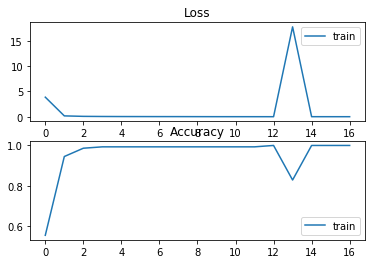

In [55]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(mod.history['loss'], label='train')
#pyplot.plot(mod.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(mod.history['sparse_categorical_accuracy'], label='train')
#pyplot.plot(mod.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [56]:
# predict probabilities for test set
yhat_probs = model.predict(X_test.astype('float32'), verbose=0)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = np.argmax(yhat_probs,axis=1)

In [57]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve


In [58]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.972973
Precision: 0.989130
Recall: 0.916667
F1 score: 0.944444


In [59]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.952746
[[22  0  0  0]
 [ 0  5  0  0]
 [ 1  0  2  0]
 [ 0  0  0  7]]


In [60]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


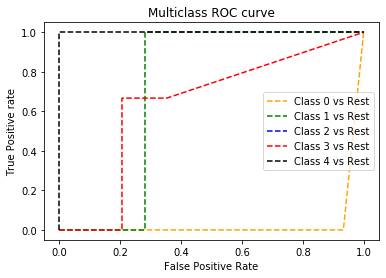

In [61]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [62]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
matrix = confusion_matrix(Y_test, yhat_classes, labels= [0, 1, 3, 4])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0  0  0]
 [ 0  5  0  0]
 [ 1  0  2  0]
 [ 0  0  0  7]]


In [63]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1, 3, 4])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      1.00      1.00         5
           3       1.00      0.67      0.80         3
           4       1.00      1.00      1.00         7

    accuracy                           0.97        37
   macro avg       0.99      0.92      0.94        37
weighted avg       0.97      0.97      0.97        37



In [64]:
model.save('./models/Without IP address/CNN-DBN/CNN')

INFO:tensorflow:Assets written to: ./models/Without IP address/CNN-DBN/CNN\assets


In [65]:
#Feature extracted from feature extractor part of deep learning model
X_ext = feature_extractor.predict(X_train)
X_ext_test = feature_extractor.predict(X_test)

In [66]:
for i in X_ext:
    print(f'{np.isnan(i).any()}')

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [67]:
from dbn.tensorflow import SupervisedDBNClassification

Instructions for updating:
non-resource variables are not supported in the long term


In [68]:
classifier = SupervisedDBNClassification(hidden_layers_structure=[128, 64],
                                         learning_rate_rbm=0.01,
                                         learning_rate=0.02,
                                         n_epochs_rbm=32,
                                         n_iter_backprop=512,
                                         batch_size=32,
                                         activation_function='relu',
                                         dropout_p=0.01)

In [71]:
classifier.fit(X_ext, Y_train)

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 4974.774902
>> Epoch 2 finished 	RBM Reconstruction error 149822.984375
>> Epoch 3 finished 	RBM Reconstruction error 279303.281250
>> Epoch 4 finished 	RBM Reconstruction error 283216.406250
>> Epoch 5 finished 	RBM Reconstruction error 287055.625000
>> Epoch 6 finished 	RBM Reconstruction error 307904.218750
>> Epoch 7 finished 	RBM Reconstruction error 286038.968750
>> Epoch 8 finished 	RBM Reconstruction error 340363.875000
>> Epoch 9 finished 	RBM Reconstruction error 334682.156250
>> Epoch 10 finished 	RBM Reconstruction error 400294.343750
>> Epoch 11 finished 	RBM Reconstruction error 409881.468750
>> Epoch 12 finished 	RBM Reconstruction error 391591.718750
>> Epoch 13 finished 	RBM Reconstruction error 410410.281250
>> Epoch 14 finished 	RBM Reconstruction error 431815.781250
>> Epoch 15 finished 	RBM Reconstruction error 378613.312500
>> Epoch 16 finished 	RBM Reconstruction error 457287.437500
>> Epoch

>> Epoch 77 finished 	ANN training loss 0.498328
>> Epoch 78 finished 	ANN training loss 0.497903
>> Epoch 79 finished 	ANN training loss 0.497487
>> Epoch 80 finished 	ANN training loss 0.497094
>> Epoch 81 finished 	ANN training loss 0.496446
>> Epoch 82 finished 	ANN training loss 0.494406
>> Epoch 83 finished 	ANN training loss 0.492457
>> Epoch 84 finished 	ANN training loss 0.491364
>> Epoch 85 finished 	ANN training loss 0.490529
>> Epoch 86 finished 	ANN training loss 0.489771
>> Epoch 87 finished 	ANN training loss 0.489060
>> Epoch 88 finished 	ANN training loss 0.488280
>> Epoch 89 finished 	ANN training loss 0.487562
>> Epoch 90 finished 	ANN training loss 0.486826
>> Epoch 91 finished 	ANN training loss 0.486103
>> Epoch 92 finished 	ANN training loss 0.485327
>> Epoch 93 finished 	ANN training loss 0.484601
>> Epoch 94 finished 	ANN training loss 0.483823
>> Epoch 95 finished 	ANN training loss 0.482998
>> Epoch 96 finished 	ANN training loss 0.482214
>> Epoch 97 finished

>> Epoch 242 finished 	ANN training loss 0.216431
>> Epoch 243 finished 	ANN training loss 0.215730
>> Epoch 244 finished 	ANN training loss 0.215102
>> Epoch 245 finished 	ANN training loss 0.214412
>> Epoch 246 finished 	ANN training loss 0.213673
>> Epoch 247 finished 	ANN training loss 0.212936
>> Epoch 248 finished 	ANN training loss 0.212214
>> Epoch 249 finished 	ANN training loss 0.211542
>> Epoch 250 finished 	ANN training loss 0.210835
>> Epoch 251 finished 	ANN training loss 0.210148
>> Epoch 252 finished 	ANN training loss 0.209466
>> Epoch 253 finished 	ANN training loss 0.208761
>> Epoch 254 finished 	ANN training loss 0.208021
>> Epoch 255 finished 	ANN training loss 0.207268
>> Epoch 256 finished 	ANN training loss 0.206559
>> Epoch 257 finished 	ANN training loss 0.205884
>> Epoch 258 finished 	ANN training loss 0.205251
>> Epoch 259 finished 	ANN training loss 0.204540
>> Epoch 260 finished 	ANN training loss 0.203818
>> Epoch 261 finished 	ANN training loss 0.203111


>> Epoch 406 finished 	ANN training loss 0.047341
>> Epoch 407 finished 	ANN training loss 0.046742
>> Epoch 408 finished 	ANN training loss 0.046221
>> Epoch 409 finished 	ANN training loss 0.045731
>> Epoch 410 finished 	ANN training loss 0.045254
>> Epoch 411 finished 	ANN training loss 0.044736
>> Epoch 412 finished 	ANN training loss 0.044260
>> Epoch 413 finished 	ANN training loss 0.043799
>> Epoch 414 finished 	ANN training loss 0.043305
>> Epoch 415 finished 	ANN training loss 0.042880
>> Epoch 416 finished 	ANN training loss 0.042409
>> Epoch 417 finished 	ANN training loss 0.041943
>> Epoch 418 finished 	ANN training loss 0.041564
>> Epoch 419 finished 	ANN training loss 0.041142
>> Epoch 420 finished 	ANN training loss 0.040737
>> Epoch 421 finished 	ANN training loss 0.040456
>> Epoch 422 finished 	ANN training loss 0.040037
>> Epoch 423 finished 	ANN training loss 0.039645
>> Epoch 424 finished 	ANN training loss 0.039268
>> Epoch 425 finished 	ANN training loss 0.038885


SupervisedDBNClassification(batch_size=32, dropout_p=0.01,
                            idx_to_label_map={0: 0, 1: 1, 2: 4, 3: 3},
                            l2_regularization=1.0,
                            label_to_idx_map={0: 0, 1: 1, 3: 3, 4: 2},
                            learning_rate=0.02, n_iter_backprop=512,
                            verbose=True)

In [73]:
# predict probabilities for test set
yhat_probs = classifier.predict(X_ext_test)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = yhat_probs# np.argmax(yhat_probs,axis=1)

In [74]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.972973
Precision: 0.958333
Recall: 0.916667
F1 score: 0.927273


In [75]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.953750
[[22  0  0  0]
 [ 0  5  0  0]
 [ 0  1  2  0]
 [ 0  0  0  7]]


In [76]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


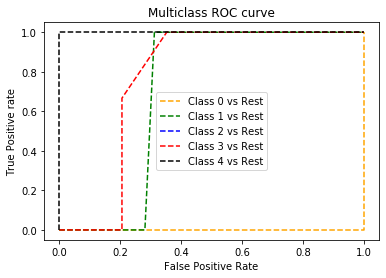

In [77]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [78]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1, 3, 4])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0  0  0]
 [ 0  5  0  0]
 [ 0  1  2  0]
 [ 0  0  0  7]]


In [79]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1, 3, 4])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.83      1.00      0.91         5
           3       1.00      0.67      0.80         3
           4       1.00      1.00      1.00         7

    accuracy                           0.97        37
   macro avg       0.96      0.92      0.93        37
weighted avg       0.98      0.97      0.97        37



In [113]:
classifier.save('./models/Without IP address/CNN-DBN/DBN.pkl')